- Can we predict more precisely in the future?
- Visualize
- Try other companies - define them
- Find new features (Sentiment)
- Baseline model (https://www.danerwealth.com/blog/the-terrible-track-record-of-wall-street-forecasts)


In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


In [2]:
import yfinance as yf

# Define the ticker symbol for S&P 500 (SPY is an ETF that tracks the S&P 500)
ticker_symbol = "META"

# Set the start and end dates for the data
start_date = "2020-01-10"  # Replace with your desired start date
end_date = "2024-01-10"    # Replace with your desired end date

# start_date = "2019-08-01"  # Replace with your desired start date
# end_date = "2023-08-01"  


# Use yfinance to download the data
amazon_stock = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
amazon_stock.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close   
Date                                                                     
2020-01-10  219.199997  219.880005  217.419998  218.059998  218.059998  \
2020-01-13  219.600006  221.970001  219.210007  221.910004  221.910004   
2020-01-14  221.610001  222.380005  218.630005  219.059998  219.059998   
2020-01-15  220.610001  221.679993  220.139999  221.149994  221.149994   
2020-01-16  222.570007  222.630005  220.389999  221.770004  221.770004   

              Volume  
Date                  
2020-01-10  12119400  
2020-01-13  14463400  
2020-01-14  13288900  
2020-01-15  10036500  
2020-01-16  10015300

In [3]:
import pandas as pd

amazon_stock.index = pd.to_datetime(amazon_stock.index)

# Reset the index to make "Date" a regular column
amazon_stock.reset_index(drop=False, inplace=True)

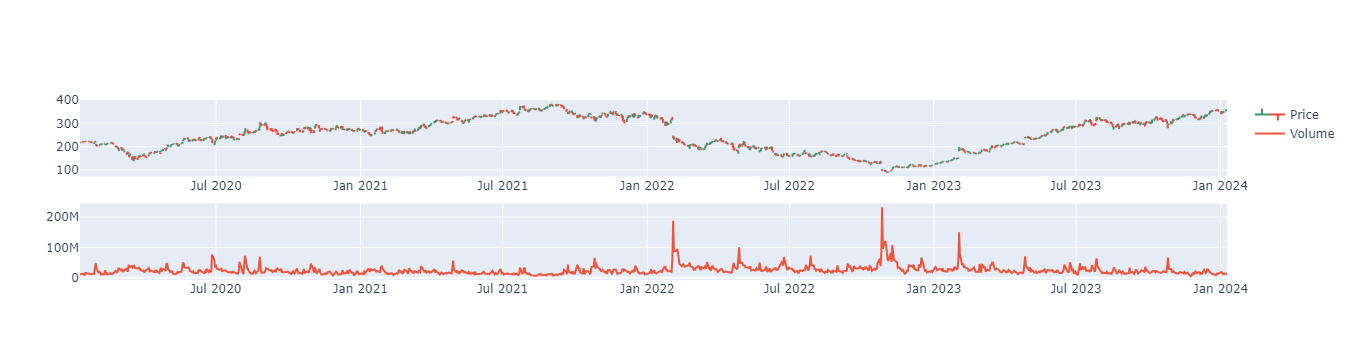

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=amazon_stock.Date,
                      open=amazon_stock.Open,
                      high=amazon_stock.High,
                      low=amazon_stock.Low,
                      close=amazon_stock.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

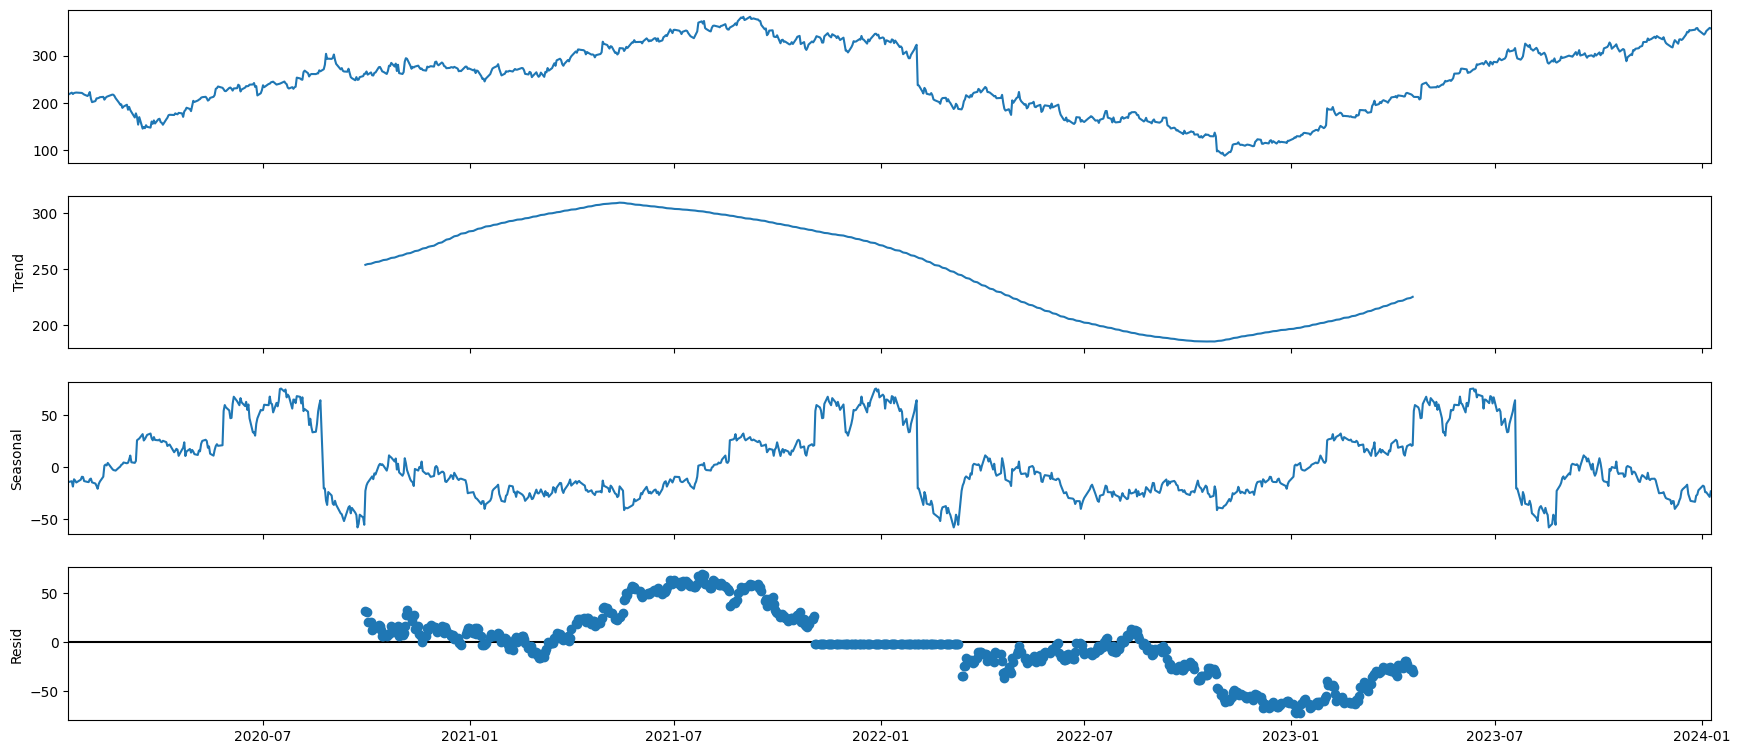

In [5]:
df_close = amazon_stock[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

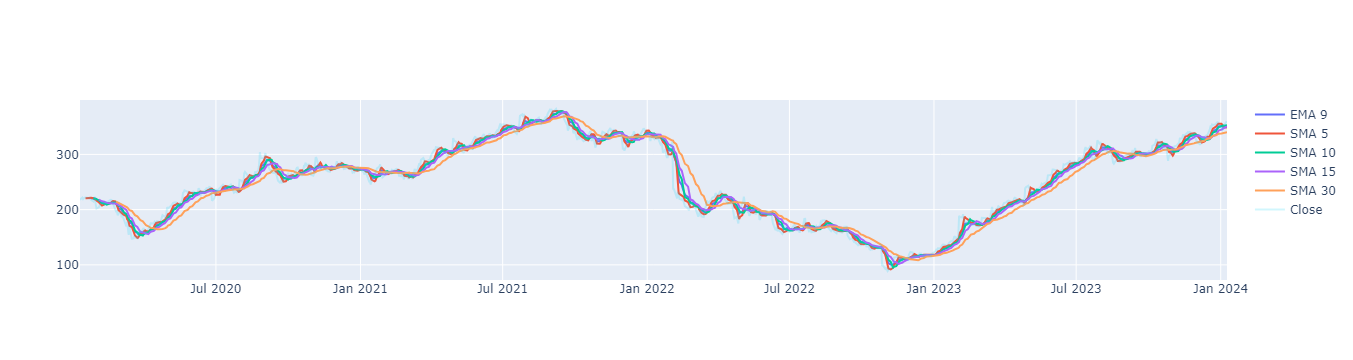

In [6]:
# Creating technical indicators - exponential moving averages and short moving averages
amazon_stock['EMA_9'] = ta.ema(amazon_stock['Close'], length=9, fillna=True).shift()
amazon_stock['SMA_5'] = ta.sma(amazon_stock['Close'], length=5, fillna=True).shift()
amazon_stock['SMA_10'] = ta.sma(amazon_stock['Close'], length=10, fillna=True).shift()
amazon_stock['SMA_15'] = ta.sma(amazon_stock['Close'], length=15, fillna=True).shift()
amazon_stock['SMA_30'] = ta.sma(amazon_stock['Close'], length=30, fillna=True).shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=amazon_stock.Date, y=amazon_stock.Close, name='Close', opacity=0.2))
fig.show()

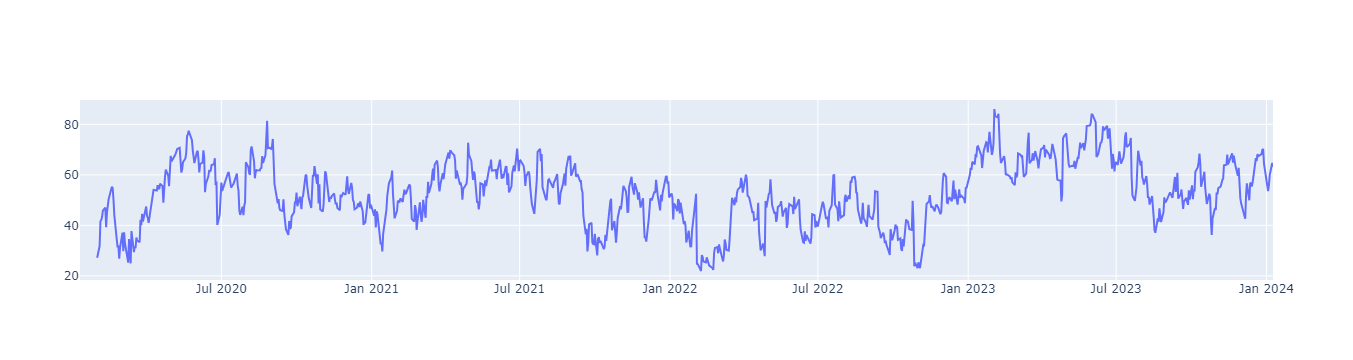

In [7]:
# Creating relative strength index
amazon_stock['RSI'] = ta.rsi(amazon_stock['Close'], length=14, fillna=True)

# Plot RSI
fig = go.Figure(go.Scatter(x=amazon_stock['Date'], y=amazon_stock['RSI'], name='RSI'))
fig.show()

In [8]:
# Creating technical indicators - Moving Average Convergence Divergence (MACD), MACD signal & MACD difference
amazon_stock[['MACD', 'MACD_signal', 'MACD_diff']] = ta.macd(amazon_stock['Close'], fast=12, slow=26, signal=9, fillna=True)


In [9]:
# Shifting the close column -1 back to reflect tomorrow's price
amazon_stock['close_tmr'] = amazon_stock['Close'].shift(-1)
amazon_stock['close_today'] = amazon_stock['Close']

In [10]:
# Creating technical indicators OBV (On-Balance Volume) and ROC (Rate of Change) 
amazon_stock['OBV'] = (amazon_stock['Volume'] * ((amazon_stock['close_today'] - amazon_stock['close_today'].shift(1)) > 0)).cumsum()
amazon_stock['ROC'] = amazon_stock['Close'].pct_change() * 100  # Calculate percentage change


In [11]:
# Removing the first 33 rows due to the moving averages and removing last row due to shift in close price (close_tmr)
amazon_stock = amazon_stock.iloc[33:]
amazon_stock = amazon_stock[:-1]   
amazon_stock.index = range(len(amazon_stock))

In [12]:
# Using numerical version of year, month and day as features 
amazon_stock['Year'] = amazon_stock['Date'].dt.year
amazon_stock['Month'] = amazon_stock['Date'].dt.month
amazon_stock['Day'] = amazon_stock['Date'].dt.day

In [13]:
# Convert pandas_ta columns to numeric (currently objects not recognized by xgbregressor)
cols_to_convert = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff']
amazon_stock[cols_to_convert] = amazon_stock[cols_to_convert].apply(pd.to_numeric, errors='coerce')

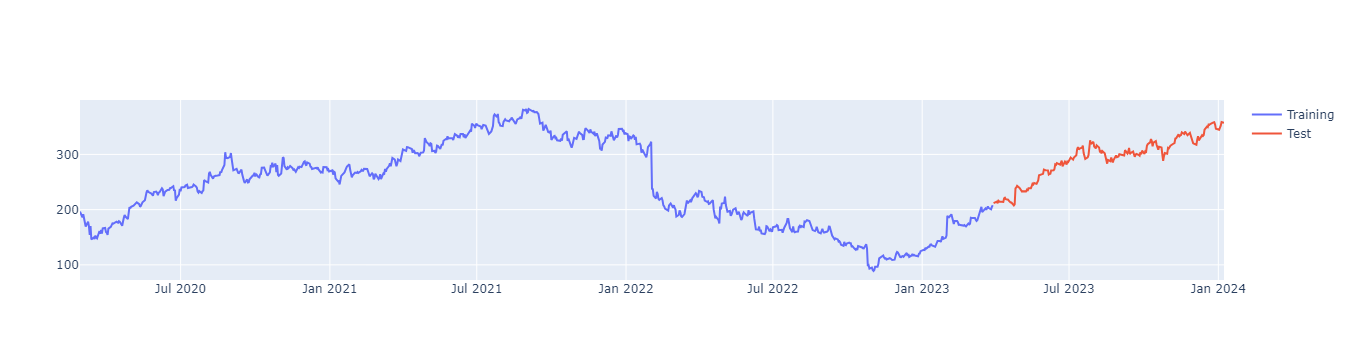

In [14]:
from sklearn.model_selection import train_test_split

# Set the size for the test set
test_size = 0.20

# Splitting the data into training and test set
train_df, test_df = train_test_split(amazon_stock, test_size=test_size, shuffle=False)

# Ensuring the temporal order is maintained - Timeseries
train_df = train_df.sort_values(by='Date')
test_df = test_df.sort_values(by='Date')

# Visualizing train and test data
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.close_tmr, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.close_tmr,  name='Test'))
fig.show()

In [15]:
# drop_cols = ['Date', 'Open', 'Low', 'High', 'Adj Close', 'Volume', 'OBV', 'ROC']  # Date, Open, High, Low, Close, Volume, OpenInt

# # Assuming train_df, valid_df, and test_df are your DataFrames
# train_df_sent = train_df_sent.drop(columns=drop_cols)
# valid_df_sent = valid_df_sent.drop(columns=drop_cols)
# test_df_sent = test_df_sent.drop(columns=drop_cols)

In [16]:
# Removing unnecessary features from train and test df
train_df = train_df.drop(columns=['Open', 'High', 'Low','Date', 'Adj Close', 'Volume', 'Close', 'MACD_diff', 'ROC', 'OBV'])  # Date,  Close, Volume, OpenInt)
test_df = test_df.drop(columns=['Open', 'High', 'Low','Date', 'Adj Close', 'Volume', 'Close', 'MACD_diff', 'ROC', 'OBV'])  # Date,  Close, Volume, OpenInt)

In [17]:
# Making copies for scaling
train_df_scaled = train_df.copy()
test_df_scaled = test_df.copy()

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame with the features you want to scale
columns_to_scale = ['EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal', 'close_tmr', 'close_today']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns and transform the data
train_df_scaled[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
test_df_scaled[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

In [19]:
# Extracting target and features for training
y_train = train_df['close_tmr'].copy()
X_train = train_df.drop(['close_tmr'], axis=1)

# Extracting target and features for testing
y_test = test_df['close_tmr'].copy()
X_test = test_df.drop(['close_tmr'], axis=1)

# Checking for NaN
X_train.isna().sum()

EMA_9          0
SMA_5          0
SMA_10         0
SMA_15         0
SMA_30         0
RSI            0
MACD           0
MACD_signal    0
close_today    0
Year           0
Month          0
Day            0
dtype: int64

In [20]:
# from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


# # Create a smaller parameter grid
# param_dist = {
#     'n_estimators': [50, 100, 150, 200, 250],
#     'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
#     'max_depth': [5, 8, 10, 12, 15],
#     'gamma': [0.001, 0.005, 0.01, 0.02, 0.05],
#     'random_state': [42]
# }

# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Create RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
#                                    scoring='neg_mean_squared_error', n_iter=5, cv=3, random_state=42)

# # Fit the model with the random parameter search using the smaller dataset
# random_search.fit(X_train, y_train)

# # Get the best parameters from the random search
# best_params_random = random_search.best_params_
# print(f'Best Parameters (Randomized Search): {best_params_random}')

# # Get the best model from the random search
# best_xgb_model_random = random_search.best_estimator_

# Set the parameters
gamma_val = 0.01
learning_rate_val = 0.01
max_depth_val = 5
n_estimators_val = 300
random_state_val = 42

# Create the XGBRegressor with the specified parameters
xgb_reg = XGBRegressor(
    gamma=gamma_val,
    learning_rate=learning_rate_val,
    max_depth=max_depth_val,
    n_estimators=n_estimators_val,
    random_state=random_state_val
)

xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
import numpy as np
# Make predictions on the test set
y_test_pred = xgb_reg.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f'Test RMSE: {rmse_test}')

Test RMSE: 10.842643913164


In [22]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Calculate MAPE on the test set
mape_test = calculate_mape(y_test, y_test_pred)
print(f'Test MAPE: {mape_test:.2f}%')

Test MAPE: 2.82%


In [23]:
import numpy as np
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_test_pred[:5]}')

y_true = [211.94000244 213.07000732 214.72000122 211.47999573 216.1000061 ]
y_pred = [211.33388 217.74477 216.91869 216.23776 216.52982]


In [27]:
from sklearn.metrics import accuracy_score, classification_report

k = 5 # Set the number of days to predict ahead

# Convert regression predictions to binary labels (1 for price up, 0 for price down)
predicted_direction = np.where(y_test_pred[k:] > y_test_pred[:-k], 1, 0)

# Create true binary labels based on the actual price movements
true_direction = np.where(y_test.values[k:] > y_test.values[:-k], 1, 0)


# Calculate accuracy and other classification metrics
accuracy = accuracy_score(true_direction, predicted_direction)
classification_report_result = classification_report(true_direction, predicted_direction)


print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)

Accuracy: 0.7894736842105263
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        69
           1       0.82      0.85      0.84       121

    accuracy                           0.79       190
   macro avg       0.77      0.77      0.77       190
weighted avg       0.79      0.79      0.79       190



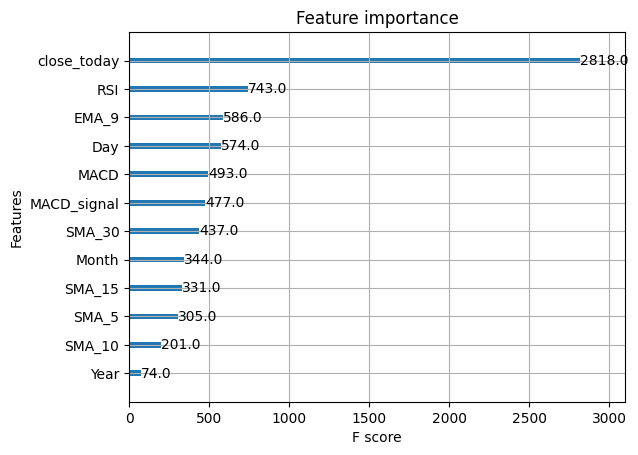

In [25]:
plot_importance(xgb_reg);

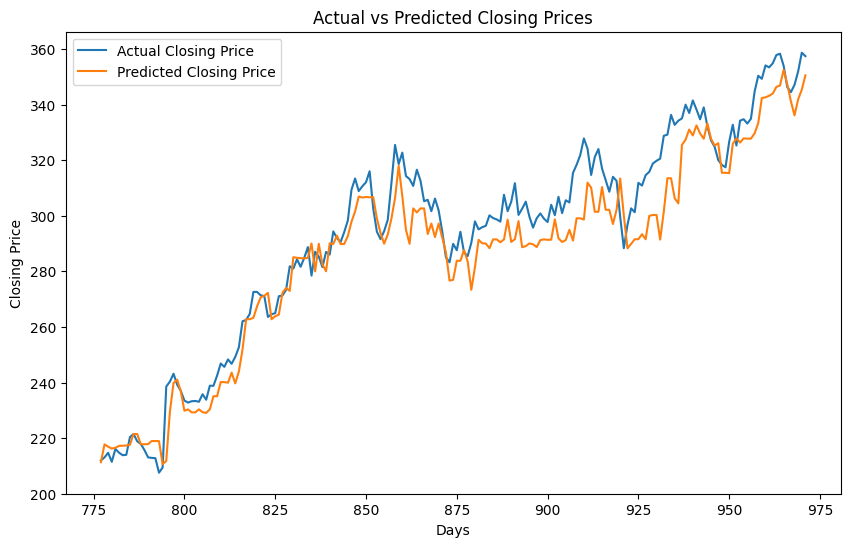

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot actual closing prices
plt.plot(y_test.index, y_test.values, label='Actual Closing Price')

# Plot predicted closing prices
plt.plot(y_test.index, y_test_pred, label='Predicted Closing Price')

plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()